# Random Forest Classification

## Importing the libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV    # GridSearchCV is used to find the best model and the best parameters
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import _joblib


import numpy as np
import pandas as pd

## Importing the dataset

In [2]:
dataset = pd.read_csv('../data/processed/final_data.csv')
X = dataset.iloc[:, 2:-1].values    # Exclude the first two columns user_id and product_id
y = dataset.iloc[:, -1].values

# Feature Scaling

In [3]:
# sc = StandardScaler()
# X = sc.fit_transform(X[:, 4:])
# X

## Encoding categorical data
### One Hot Encoding

In [4]:
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder='passthrough'
)
X = np.array(ct.fit_transform(X).toarray())

## Splitting the dataset into the Training set and Test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)

In [6]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4891, 1035)
Number transactions y_train dataset:  (4891,)
Number transactions X_test dataset:  (2097, 1035)
Number transactions y_test dataset:  (2097,)


# Applying SMOTE because the dataset is imbalanced (more 0 than 1)

In [15]:
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Training the Random Forest Classification model on the Training set

n_estimators : int ( means number of trees in the forest)
random_state : int ( means the seed used by the random number generator)

In [8]:
classifier = RandomForestClassifier(
    n_estimators=100,   # Number of trees in the forest
    max_depth=10,       # Maximum depth of the tree
    min_samples_split=2,    # The minimum number of samples required to split an internal node
    min_samples_leaf=1,     # The minimum number of samples required to be at a leaf node
    bootstrap=True,     # Whether bootstrap samples are used when building trees
    # criterion='entropy',    # The function to measure the quality of a split
    # random_state=0,      # The seed used by the random number generator
)
classifier.fit(X_resampled, y_resampled)    # Fit the model 

RandomForestClassifier(max_depth=10)

## Predicting the Test set results

In [9]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.52      0.66      1669
           1       0.28      0.72      0.40       428

    accuracy                           0.56      2097
   macro avg       0.58      0.62      0.53      2097
weighted avg       0.76      0.56      0.61      2097



## Making the Confusion Matrix

In [10]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[876 793]
 [121 307]]


0.56413924654268

# Applying Grid Search to find the best parameters

In [11]:
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=classifier, param_grid=parameters, scoring='accuracy', cv=2, n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_  # is a method of the GridSearchCV class that returns the best accuracy
best_parameters = grid_search.best_params_  # is a method of the GridSearchCV class that returns the best parameters


print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)  # Find best params and best accuracy

Fitting 2 folds for each of 162 candidates, totalling 324 fits
Best Accuracy: 78.14 %
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


# Applying k-Fold Cross Validation

In [12]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 78.12 %
Standard Deviation: 0.01 %


# Visualising the Confusion Matrix

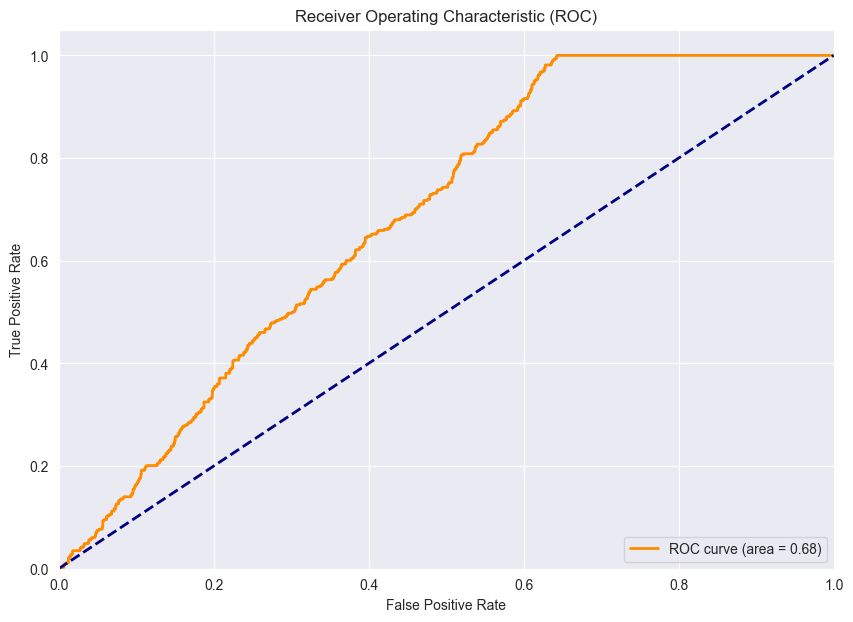

In [13]:
# Compute prediction probabilities
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculates the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# View the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Save the model

In [14]:
_joblib.dump(classifier, 'random_forest_classification.joblib')

['random_forest_classification.joblib']